# Airbnb Data: Boston and Seattle as an Example

In this notebook, I will analyze two datasets from the [inside airbnb website](http://insideairbnb.com/get-the-data.html). The datasets are for two US cities; Boston and Seattle. I will start by examining and cleaning the data for further statistical analysis. The cleaning steps will focus on removing and handling missing observations through imputation techniques. I will create a generic data pipeline so that both datasets will be preprocessed correctly using the same data engineering steps. I will save the clean preprocessed versions of both datasets into SQL databases. The SQL databases can be loaded quickly in the future for more detailed analysis. Let's start by importing the needed libraries. 

In [1]:
# import packages
import warnings
from read_data import read_data
from clean_data import clean_data
from data_visualization import visualizations

# improve figures quality
%config InlineBackend.figure_format = "retina"

# suppress warninnigs
warnings.filterwarnings("ignore")

The project has three modules: 
- ```read_data```: read the original Airbnb data for both cities.
- ```clean_data```: preprocess the Airbnb data.
- ```data_visulization```: create plots for EDA analysis.

## Business Questions

In this notebook, I will discuss the steps for extracting, loading and transforming the Airbnb data to the best shape for performing the EDA analysis. The clean data is used to create a tableau story to answer four business questions:

- _host description and reviewers comments_: 
    - How do hosts like to describe their listings? 
    - How do visitors like to express their stay experience?
- _Identity Verifications_:  
    - How hosts verify their identity?
    - How visitors verify their identity? 
- _Customer Acquisition_:
    - What is the difference in the rate of customer acquisition between Boston and Seattle?
- _Relationship between price, beds, bedrooms and baths_:
    - Is there a relationship between the price and the number of beds or bedrooms or baths?
    
    
The final tableau story is accessed through the following [link](https://public.tableau.com/views/AirbnbRentalsOverviewofBostonandSeattle/Airbnb?:embed=y&:display_count=yes&:origin=viz_share_link).

## ETL Pipeline Development

## Boston City
### Boston Lisiting

Let's start with the Boston dataset. The Boston dataset has two seperate files; one contains observations about the hosts and their Airbnb units and the other has information about the reviewers who stayed at these units and their comments.
We will look first at the listings dataset. For this dataset, I created a ```read_data``` function to read the data from a csv file. I also dropped unnecessary columns. These dropped columns contain private information about the host, URL links to their pictures and last date this info was scrapped from the Airbnb API. Such info is not vital for our exploratory data analysis.

In [2]:
boston_listings = read_data.read_data("data files/source data/boston-airbnb-open-data/listings.csv", 
                                      index_col="id",
                                      drop_columns=[], 
                                      parse_date=["first_review", "last_review", "host_since"])
boston_listings.head()

,summary,space,experiences_offered,neighborhood_overview,transit,access,interaction,house_rules,host_since,host_location,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
12147973,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,none,"Roslindale is quiet, convenient and friendly. ...","The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,2015-04-15,"Boston, Massachusetts, United States",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
3075044,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,none,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,2012-06-07,"Boston, Massachusetts, United States",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
6976,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",2009-05-11,"Boston, Massachusetts, United States",...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
1436513,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,none,Roslindale is a lovely little neighborhood loc...,There are buses that stop right in front of th...,The basement has a washer dryer and gym area. ...,We do live in the house therefore might be som...,- The bathroom and house are shared so please ...,2013-04-21,"Boston, Massachusetts, United States",...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
7651065,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...",none,"I love the proximity to downtown, the neighbor...",From Logan Airport and South Station you have...,You will have access to the front and side por...,I love my city and really enjoy sharing it wit...,"Please no smoking in the house, porch or on th...",2014-05-11,"Boston, Massachusetts, United States",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


### Missing Values Distributions
#### Columns with NANs

As we can see, the dataset has 76 columns. The next step is to examine the distribution of NANs per column or row. This will give us an idea about how we should approach the data cleaning process. I created a function called ```nans_distribution``` the function can return the distribution of missing values in the dataset per column or row. The function takes a parameter called threshold, which determines the limit for percentage of missing values per row or column.

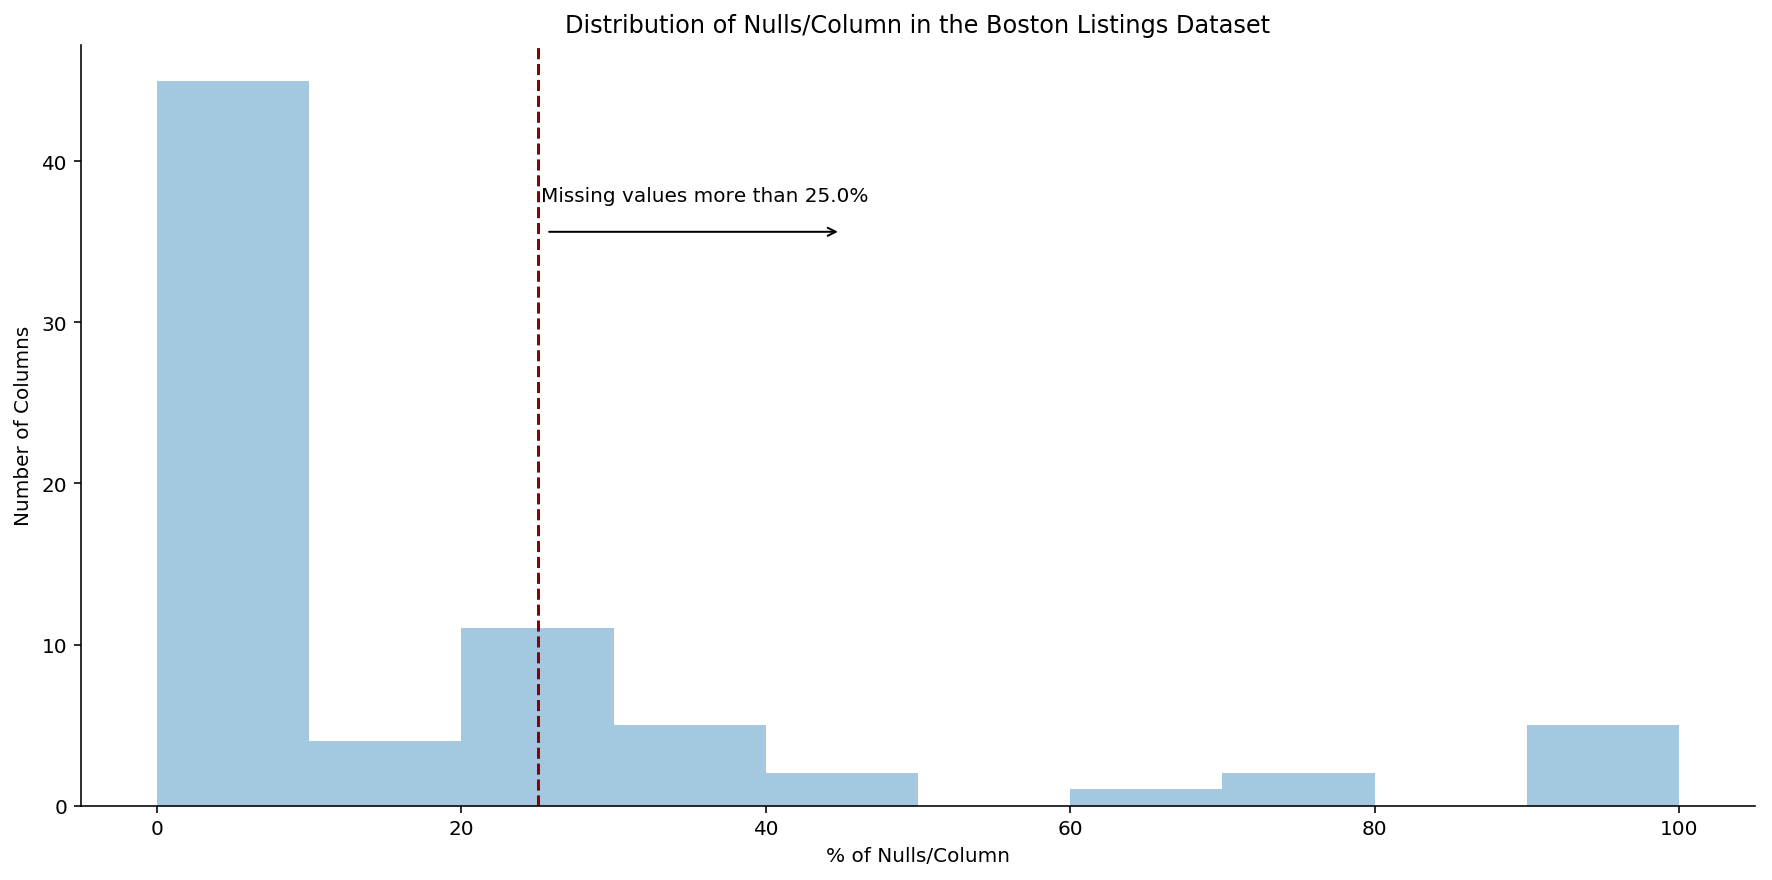

In [3]:
# show the distribution of missing values per column
visualizations.nans_distribution(title="Distribution of Nulls/Column in the Boston Listings Dataset",
                                 dataframe=boston_listings)

The above figure shows that the majority of columns have missing values of less than 25%. Any columns above this threshold will be dropped from the dataset. The ```drop_missing``` function drop columns or row with missing values exceeding a threshold [percentage of missing values].

In [4]:
# drop missing columns
boston_listings = clean_data.drop_missing(boston_listings, threshold=0.25)

#### Rows with NANs

Let's check the missing values distribution per row now.

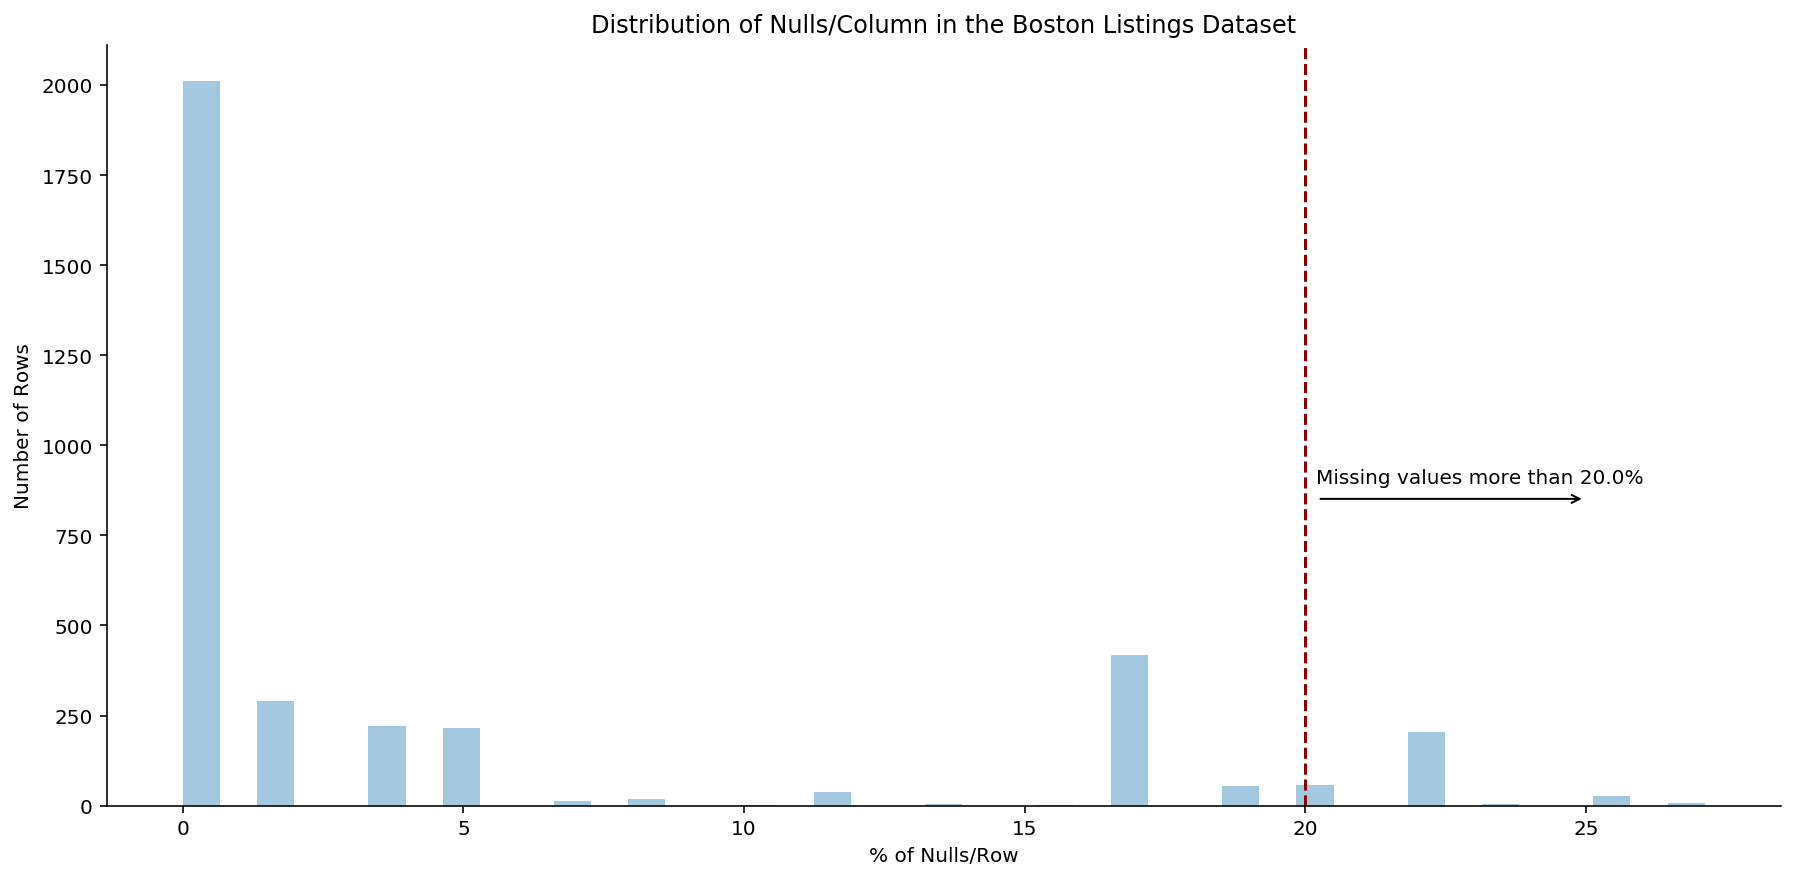

In [5]:
visualizations.nans_distribution(title="Distribution of Nulls/Column in the Boston Listings Dataset",
                                 row=True,
                                 threshold=0.2,
                                 dataframe=boston_listings)

Let's drop rows with NANs above the selected threshold  

In [6]:
# drop missing rows
boston_listings = clean_data.drop_missing(boston_listings, row = True, threshold = 0.2)

### The Cleaning Process Rationale

After dropping missing rows and columns, we are left with the following number of Nulls for numerical and categorical features. We will use the following strategy to handle missing values:

#### For Numerical Features:


- Use the ```median``` value of review scors per column. Generally speaking, each user will have review scores for location, value, check-in, communication and cleanliness that are consistent with his or her history of hosting guests. Using the mean or median of the entire dataset is not the best assumption as this could be much lower than his or her history of reviews. I tried to group users by id and then estimate the median for each user. The problem was that "if a user is missing any of his or her review scores, then other scores happen to be missing as well". Therefore, grouping the review scores per each host and using the median of these scores to estimate missing values is not feasible. The second option is to use median score per each column as an estimate for missing values. Removing around 600 rows from the datset is not the best option. we will use the median of each column even if it's not the best option. 

| Column Name                 | # of Nulls        |
| --------------------------  | ----------------- |
| review_scores_accuracy      |        581        |
| review_scores_location      |        580        |
| review_scores_value         |        579        |
| review_scores_checkin       |        578        |
| review_scores_communication |        576        |
| review_scores_cleanliness   |        576        |

- Use ```median``` per column for the following columns (```reviews_per_month, host_acceptance_rate, host_response_rate, bathrooms, bedrooms, beds```). Median is not sensitive to outliers so it can be used as an estimate for missing values.

| Column Name                 | # of Nulls        |
| --------------------------  | ----------------- |
| reviews_per_month           |        514        |
| host_acceptance_rate        |        236        |
| host_response_rate          |        236        |
| bathrooms                   |        12         |
| bedrooms                    |        10         |
| beds                        |        6          |

**Note**:
- ```host_acceptance_rate, host_response_rate, price, extra_people``` _are treated as categorical features. Columns of such features contains letters like (%,$). These columns will be parsed and converted to numerical features_.

#### For Categorical Features:

 - ```zipcode```: drop all missing rows. In each neighborhood, we could have multiple zip codes. Using lat, long, neighborhood location ...etc. will not help in such cases. The number of rows with missing zipcode is very small so we can drop these rows.
 - ```host_location```: contains redundant info from ```host_neighbourhood and neighborhood ``` so drop it as well. 
 - ```host_neighbourhood and neighborhood ```:  most rows had the same values for these two columns. Therefore, drop neighbourhood and keep host_neighbourhood because it has less missing values. The zip code is used to find the host_neighbourhood for missing rows.
 - ```market and city```: use zip to find the same market. if multiple makets are returned, choose the mode.
 - ```summary```: replace nan with 'missing keyword'. This is a categorical column where each apartment has a specific summary provided by the user. It's better to replace missing summaries with the keyword 'missing' rather than dropping this entire column or its rows from the dataset and losing information.
 - ```property_type```: we can drop these two rows with their missing property types or use the mode as an estimate. I prefer to use the mode as a start. It's unlikely that removing or keeping these two rows will have a significant impact on the analysis. 
 
 Categroical Columns status:
 
| Column Name        |  Number of Fulls  |
| -----------------  | ----------------- |
| neighbourhood      |        503        |
| host_response_time |        236        |
| host_neighbourhood |        300        |
| summary            |        141        |
| zipcode            |        28         |
| market             |        13         |
| host_location      |        10         |
| property_type      |         2         |
| city               |         2         |

In [7]:
clean_data.print_column_status(boston_listings)

Numerical Columns status:

╒═════════════════════════════╤═══════════════════╕
│ Column Name                 │  Number of Nulls  │
╞═════════════════════════════╪═══════════════════╡
│ review_scores_accuracy      │        523        │
├─────────────────────────────┼───────────────────┤
│ review_scores_location      │        522        │
├─────────────────────────────┼───────────────────┤
│ review_scores_value         │        521        │
├─────────────────────────────┼───────────────────┤
│ review_scores_checkin       │        520        │
├─────────────────────────────┼───────────────────┤
│ review_scores_communication │        518        │
├─────────────────────────────┼───────────────────┤
│ review_scores_cleanliness   │        518        │
├─────────────────────────────┼───────────────────┤
│ review_scores_rating        │        513        │
├─────────────────────────────┼───────────────────┤
│ reviews_per_month           │        459        │
├─────────────────────────────┼──────

The clean_data module contains all the coding used in the cleaning process: 
- cleaning, parsing and imputing missing values in numerical columns.
    - functions used: ```money_to_numeric, percentage_to_numeric, handle_numeric```
- cleaning, parsing and imputing missing values in categorical columns. 
    - functions used: ```handle_categorical, search_similar_zip, get_mode, get_mode_by_zip```
- dropping unnecessary columns.
    - functions used: ```columns_missing_list```
- dropping duplicates.
    - functions used: ```handle_repetitive_data```
    
These functions are called internally from the ```clean_data``` module therefore everything is wrapped or encapsulated inside this moduel. We just need to call the ```clean_data``` function from the ```clean_data module``` and it will return a clean dataframe.

In [8]:
boston_listings = clean_data.clean_data(boston_listings)

_Please note that I didn't clean the datetime columns. We can't just impute the missing values for these columns. Leaving these missing values is not a bad idea for now. Our analysis will focus on exploring both datasets. We just need to note this for now. Before ML, we can remove missing records or add specific value for missing dates ("-1", "missing"...etc.)._

### Processing Vertifications and Amenities

Verification methods and amenities were recorded as a string. Each string represents a list of verification methods used by this host to verify his or her identity or a list of amenities offered to the visitors of this host. We will parse and clean each column. Each column will be converted from a series of strings to a series of lists. The series of lists will then be transformed to a separate dataframe. The first dataframe will have records with the id of each host and his verification methods. The second dataframe will have records with the id of each host and his available amenities. These dataframes will be compiled into a database with three tables; the listings, the verification methods, and the amenities. The same ETL pipeline will be applied to each dataset.  

In [9]:
host_verifications_boston = clean_data.get_df_from_column(boston_listings, "host_verifications", "\[|\]|'|\s")
amenities_boston = clean_data.get_df_from_column(boston_listings, "amenities", "\{|\}|\"")

### Boston Reviews

We will process the boston reviews dataframe to see which keywords used by reviewers to describe their Airbnb experience. For now, we will clean the dataframe by droping rows with missing reviews.

In [10]:
boston_reviews = read_data.read_data("data files/source data/boston-airbnb-open-data/reviews.csv", 
                                     index_col="id", 
                                     drop_columns=["reviewer_name"], 
                                     parse_date=["date"])

boston_reviews = boston_reviews.dropna()
boston_reviews.head()

,listing_id,date,reviewer_id,comments
id,,,,
4724140,1178162,2013-05-21,4298113,My stay at islam's place was really cool! Good...
4869189,1178162,2013-05-29,6452964,Great location for both airport and city - gre...
5003196,1178162,2013-06-06,6449554,We really enjoyed our stay at Islams house. Fr...
5150351,1178162,2013-06-15,2215611,The room was nice and clean and so were the co...
5171140,1178162,2013-06-16,6848427,Great location. Just 5 mins walk from the Airp...


## Seattle City
### Seattle Listings

We will apply the same ETL pipeline on the Seattle City.

In [11]:
# read boston data, make id column as index 
seattle_listings = read_data.read_data("data files/source data/seattle-airbnb-open-data/listings.csv", 
                                       index_col ="id", 
                                       drop_columns=[],
                                       parse_date=["first_review", "last_review", "host_since"])

seattle_listings.head()

,summary,space,experiences_offered,neighborhood_overview,transit,host_since,host_location,host_about,host_response_time,host_response_rate,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
241032,NaN,Make your self at home in this charming one-be...,none,NaN,NaN,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
953595,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",none,"Queen Anne is a wonderful, truly functional vi...","Convenient bus stops are just down the block, ...",2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
3308979,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",none,Upper Queen Anne is a charming neighborhood fu...,A bus stop is just 2 blocks away. Easy bus a...,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
7421966,A charming apartment that sits atop Queen Anne...,NaN,none,NaN,NaN,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
278830,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,The nearest public transit bus (D Line) is 2 b...,2011-11-29,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


### Seattle Reviews

In [12]:
seattle_reviews = read_data.read_data("data files/source data/seattle-airbnb-open-data/reviews.csv", 
                                      index_col ="id", 
                                      drop_columns=["reviewer_name"], parse_date=["date"])

seattle_reviews = seattle_reviews.dropna()
seattle_reviews.head()

,listing_id,date,reviewer_id,comments
id,,,,
38917982,7202016,2015-07-19,28943674,Cute and cozy place. Perfect location to every...
39087409,7202016,2015-07-20,32440555,Kelly has a great room in a very central locat...
39820030,7202016,2015-07-26,37722850,"Very spacious apartment, and in a great neighb..."
40813543,7202016,2015-08-02,33671805,Close to Seattle Center and all it has to offe...
41986501,7202016,2015-08-10,34959538,Kelly was a great host and very accommodating ...


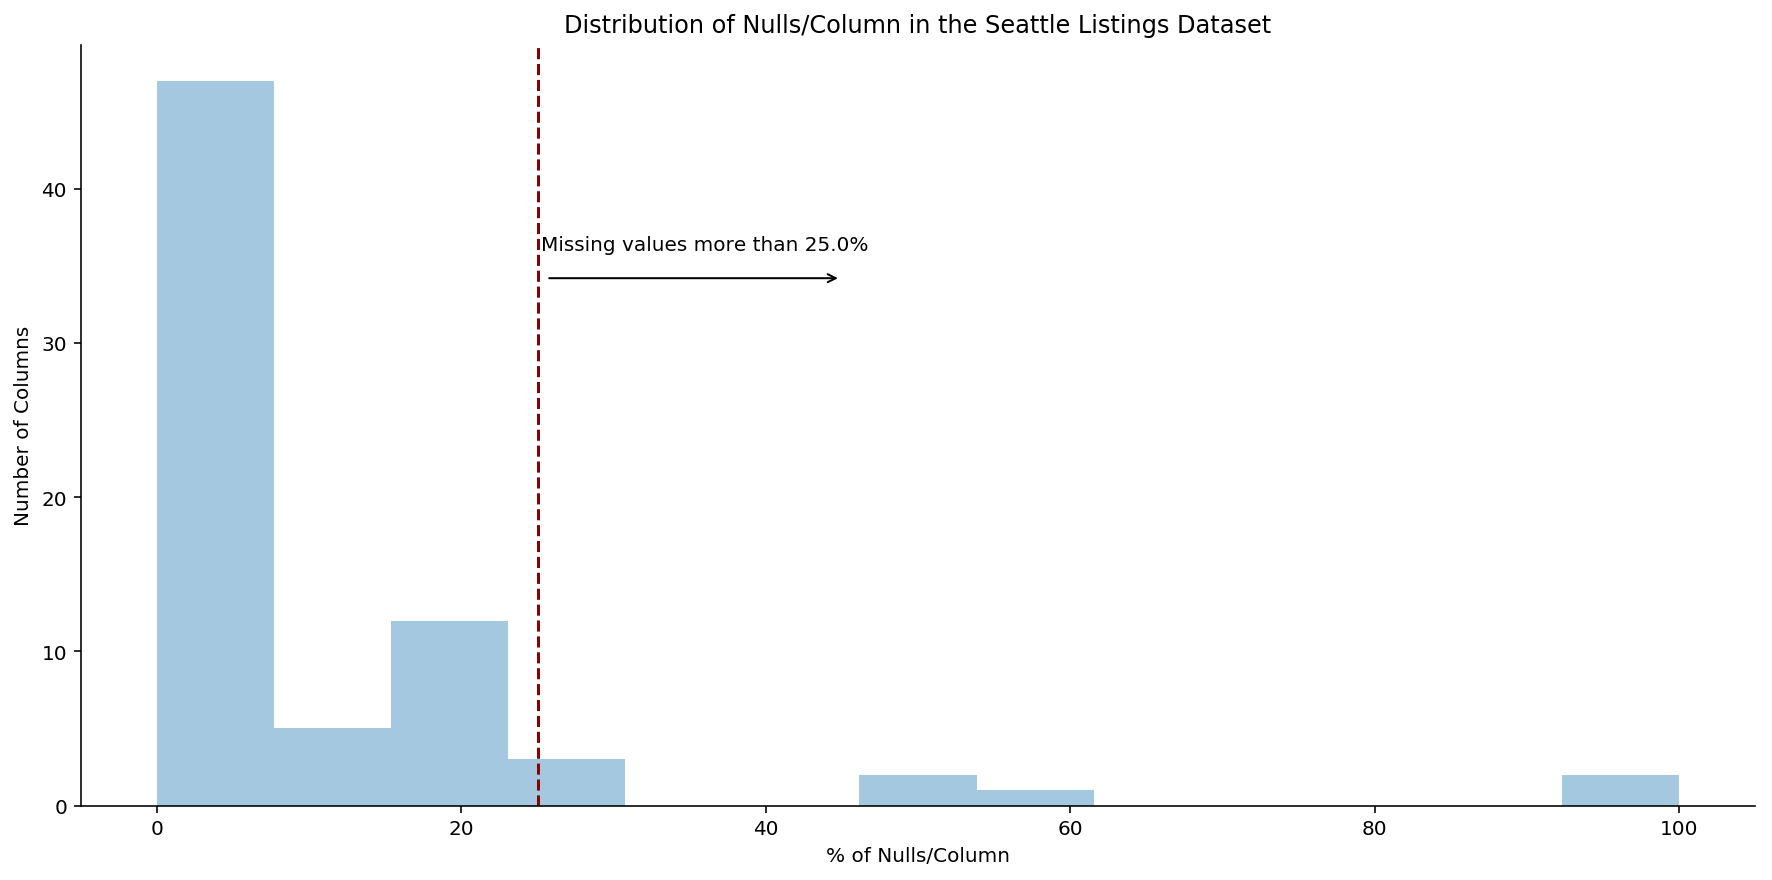

In [13]:
visualizations.nans_distribution(title="Distribution of Nulls/Column in the Seattle Listings Dataset",
                                 dataframe=seattle_listings)

In [14]:
# drop missing columns
seattle_listings = clean_data.drop_missing(seattle_listings, threshold=0.25)

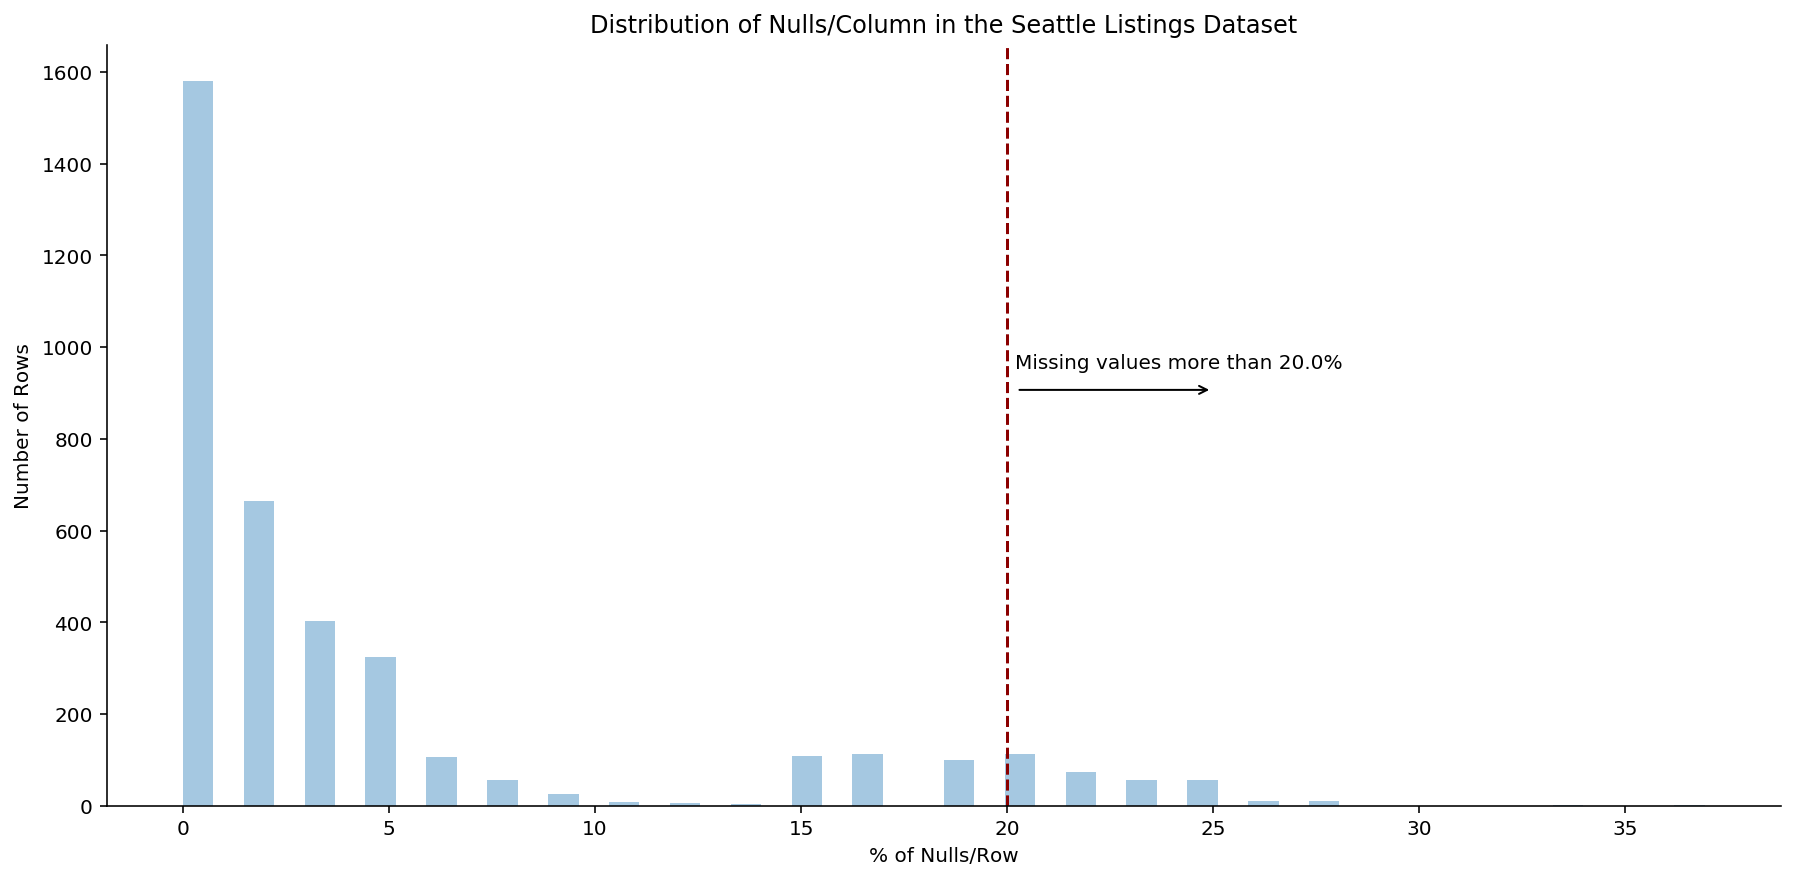

In [15]:
visualizations.nans_distribution(title="Distribution of Nulls/Column in the Seattle Listings Dataset", 
                                 row =True, 
                                 threshold=0.2,
                                 dataframe=seattle_listings)

In [16]:
# drop missing rows
seattle_listings = clean_data.drop_missing(seattle_listings, row=True, threshold=0.2)

In [17]:
clean_data.print_column_status(seattle_listings)

Numerical Columns status:

╒═════════════════════════════╤═══════════════════╕
│ Column Name                 │  Number of Nulls  │
╞═════════════════════════════╪═══════════════════╡
│ review_scores_checkin       │        450        │
├─────────────────────────────┼───────────────────┤
│ review_scores_accuracy      │        450        │
├─────────────────────────────┼───────────────────┤
│ review_scores_value         │        448        │
├─────────────────────────────┼───────────────────┤
│ review_scores_location      │        447        │
├─────────────────────────────┼───────────────────┤
│ review_scores_cleanliness   │        445        │
├─────────────────────────────┼───────────────────┤
│ review_scores_communication │        443        │
├─────────────────────────────┼───────────────────┤
│ review_scores_rating        │        439        │
├─────────────────────────────┼───────────────────┤
│ reviews_per_month           │        419        │
├─────────────────────────────┼──────

In [18]:
# ETL pipeline on seattle
seattle_listings = clean_data.clean_data(seattle_listings)
host_verifications_seattle = clean_data.get_df_from_column(seattle_listings, "host_verifications", "\[|\]|'|\s")
amenities_seattle = clean_data.get_df_from_column(seattle_listings, "amenities", "\{|\}|\"")

## Combining Seattle and Boston

We will align both datasets so that we can combine them into one large dataset.

In [20]:
seattle_listings_aliggned = clean_data.align_dataframes(boston_listings, seattle_listings)

In [21]:
# assert both dataframes are have the same columns
assert set(seattle_listings_aliggned.columns.tolist()).difference(set(boston_listings.columns.tolist())) == set()
assert set(seattle_listings_aliggned.columns.tolist()).intersection(set(boston_listings.columns.tolist())) == set(boston_listings.columns.tolist())
assert len(boston_listings.columns.tolist()) == len(seattle_listings_aliggned.columns.tolist())

# NLP Analysis for Summary and Reviews Columns

## Using WordCloud 

I used the [WordCloud](https://amueller.github.io/word_cloud/) Package to understand which words are used frequently by: 1)hosts when describing their property and 2) reviewers when commenting on their stay experience.

## Boston Vs Seattle

### Summary Column

#### Seattle

There are 808068 words in the combination of all reviews or summaries.


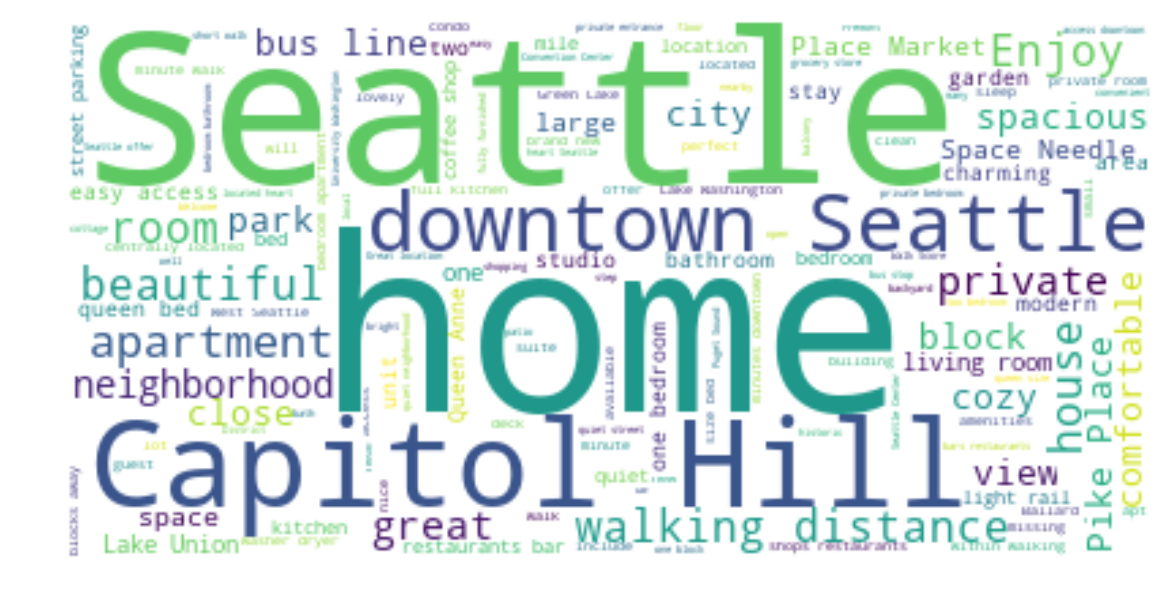

In [22]:
seattle_summary_wc = visualizations.wordcloud_image(seattle_listings, "summary")

#### Boston

There are 829565 words in the combination of all reviews or summaries.


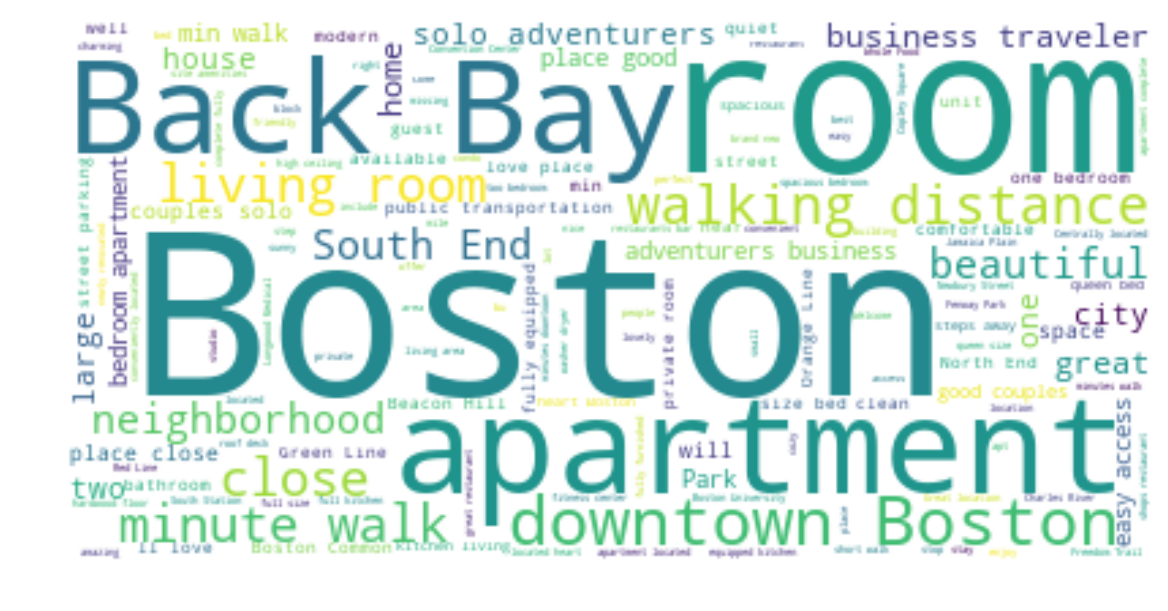

In [23]:
boston_summary_wc = visualizations.wordcloud_image(boston_listings, "summary")

### Reviews

We can do the same analysis on the reviews dataframes for each city.

#### Seattle

There are 32747568 words in the combination of all reviews or summaries.


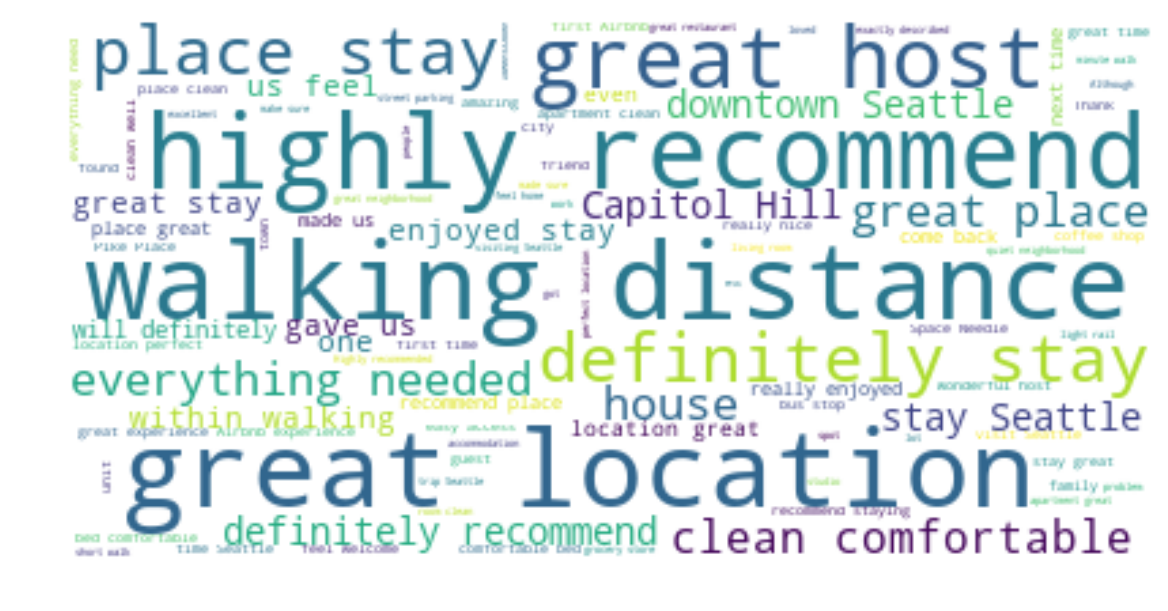

In [24]:
seattle_reviews_wc = visualizations.wordcloud_image(seattle_reviews, "comments")

#### Boston

There are 24126265 words in the combination of all reviews or summaries.


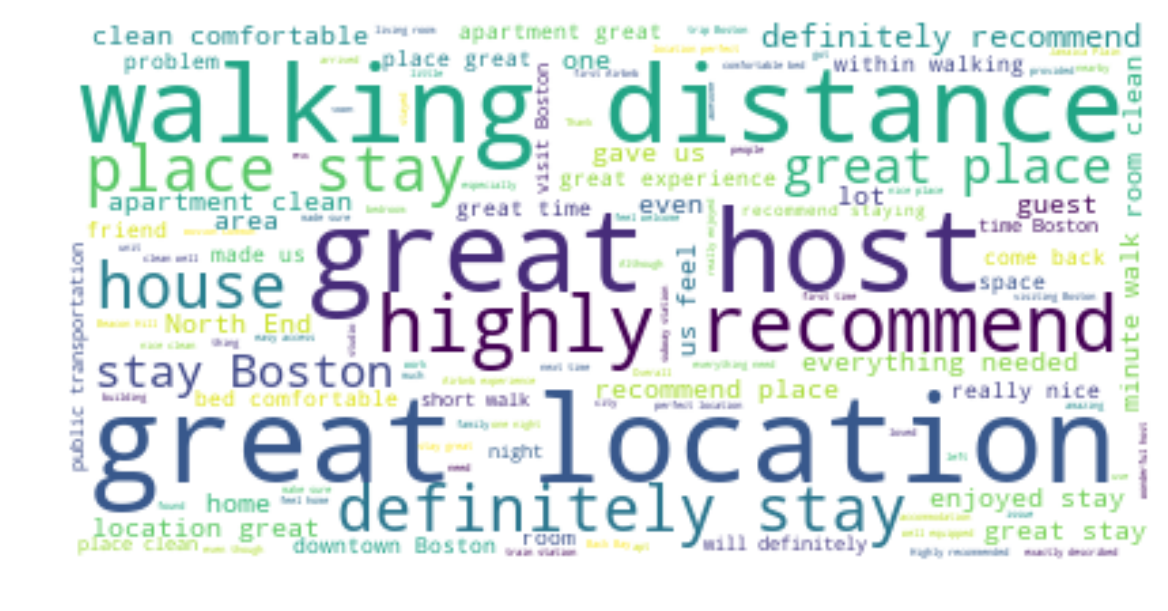

In [25]:
boston_reviews_wc = visualizations.wordcloud_image(boston_reviews, "comments")

## Data Loading

## Create database

We can save the clean data into a SQLite database or csv files. The ```generate_db``` from the ```clean_data``` module will generate a SQLite database for each city with three tables: listings, verifications and amenities.

In [26]:
# run this cell to create SQLite database for each city
clean_data.generate_db("data files/boston", [boston_listings, host_verifications_boston, amenities_boston])
clean_data.generate_db("data files/seattle", [seattle_listings, host_verifications_seattle, amenities_seattle])

We can check the SQL connection to make that everything is working as expected.

In [27]:
# check connection and read amenities table
import sqlite3
import pandas as pd
conn = sqlite3.connect("data files/boston.db")
pd.read_sql("SELECT * FROM amenities", con = conn).head()

,id,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,number_of_amenities
0,3075044,0,1,0,0,0,1,0,1,0,...,1,1,0,0,1,1,0,0,1,21
1,6976,0,1,0,0,1,1,0,0,0,...,1,1,0,0,1,1,0,0,1,18
2,7651065,0,1,1,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,1,14
3,12386020,0,1,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,1,13
4,5706985,1,0,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,13


In [28]:
# close the SQL connection
conn.close()

## Create csv files

We can save the clean data as csv files as well by using the ```generate_csv``` function. The data for each city is stored to a folder with the ```cityname```. Each folder will have separate csv files for each dataframe.  

In [29]:
# run this cell to create a folder for each city with csv files for each dataframe 
clean_data.generate_csv("boston", [boston_listings, host_verifications_boston, amenities_boston,
                        boston_reviews, boston_summary_wc, boston_reviews_wc])

clean_data.generate_csv("seattle", [seattle_listings,  host_verifications_seattle, amenities_seattle,
                         seattle_reviews, seattle_summary_wc, seattle_reviews_wc])

## EDA Analysis

I used tableau to creata a story for answering the four business questions highlighted at the beginnig of this notebook. Please check this link [link](https://public.tableau.com/views/AirbnbRentalsOverviewofBostonandSeattle/Airbnb?:embed=y&:display_count=yes&:origin=viz_share_link) 